In [1]:
import Pkg
Pkg.add("PkgServerClient")
using PkgServerClient
PkgServerClient.set_mirror("NJU")
Pkg.add("JSON3")
Pkg.add("DataFrames")
Pkg.add("JSONTables")
Pkg.add("Plots")
Pkg.add("FuzzyLogic")

   Resolving package versions...
   Installed PkgServerClient ─ v0.1.3
    Updating `C:\Users\cross\.julia\environments\v1.10\Project.toml`
  [9c9e696b] + PkgServerClient v0.1.3
    Updating `C:\Users\cross\.julia\environments\v1.10\Manifest.toml`
  [9c9e696b] + PkgServerClient v0.1.3
Precompiling project...
┌ Warning: attempting to remove probably stale pidfile
│   path = C:\Users\cross\.julia\compiled\v1.10\Plots\ld3vC_gQMF1.ji.pidfile
└ @ FileWatching.Pidfile C:\Users\cross\AppData\Local\Programs\Julia-1.10.2\share\julia\stdlib\v1.10\FileWatching\src\pidfile.jl:244
  ✓ PkgServerClient
  ✓ Plots
  ✓ Plots → UnitfulExt
  3 dependencies successfully precompiled in 84 seconds. 162 already precompiled.
   Resolving package versions...
  No Changes to `C:\Users\cross\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\cross\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\cross\.julia\environments\v1.10\Project.toml`
  No Ch

In [53]:
TargetPair = Tuple{Int, Int, Int} # x, y, speed
FILE_INDEX = 2

2

In [54]:
import JSON3
FILES_R = [
    "open_close_auto_radar_20240510_173207_88ms.jsonl",
    "open_close_auto_radar_20240510_173300_88ms.jsonl",
    "open_close_auto_radar_20240510_173518_88ms.jsonl",
    "move_vertical_short_20240510_112316_88ms.jsonl",
    "radar_20240510_113056_88ms.jsonl",
]
FILES = [
    joinpath(@__DIR__, "data", f) for f in FILES_R
]
FILE_NAME = FILES[FILE_INDEX]
global_targets::Vector{Array{TargetPair}} = []
# JSON3.readjsonlines
# https://stackoverflow.com/questions/67348301/julia-iterator-which-parses-each-line-in-file

open(FILE_NAME, "r") do f
    for m in Iterators.map(JSON3.read, eachline(f))
        targets = m["targets"]
        if targets == nothing || targets == []
            push!(global_targets, [])
            continue
        end
        function get_target(t)
            x = t["coord"][1]
            y = t["coord"][2]
            speed = t["speed"]
            return (x, y, speed)
        end
        ts = Iterators.map(get_target, targets)
        push!(global_targets, collect(ts))
    end
end

In [55]:
NullableTargetPair = Union{Nothing,TargetPair}
function get_column(
    targets::AbstractArray{Array{TargetPair}},
    col::Int,
)::Vector{NullableTargetPair}
    return map(t -> length(t) < col ? nothing : t[col], targets)
end

fst_col = get_column(global_targets, 1)
snd_col = get_column(global_targets, 2)
thd_col = get_column(global_targets, 3)

non_nothing_length = xs -> filter(x -> x != nothing, xs) |> collect |> length

println("total_length=$(length(global_targets))")
println("fst non_empty_length=$(non_nothing_length(fst_col))")
println("snd non_empty_length=$(non_nothing_length(snd_col))")
println("thd non_empty_length=$(non_nothing_length(thd_col))")

total_length=1373
fst non_empty_length=1334
snd non_empty_length=0
thd non_empty_length=0


In [56]:
function segment_continous(xs::Vector{NullableTargetPair})::Vector{Vector{TargetPair}}
    segments = []
    current_segment = []
    for x in xs
        if x == nothing
            if length(current_segment) > 0
                push!(segments, current_segment)
                current_segment = []
            end
        else
            push!(current_segment, x)
        end
    end

    # end piece check
    if length(current_segment) > 0
        push!(segments, current_segment)
    end
    return segments
end

fst_segments = segment_continous(fst_col)
each_length = map(length, fst_segments)
println("each_length=$(each_length)")

each_length=[1334]


In [57]:
WINDOW_SIZE = 14
function sliding_window_continous(xs::Vector{TargetPair}, window_size::Int)::Vector{Vector{TargetPair}}
    if length(xs) < window_size
        return []
    end
    return [xs[i:i+window_size-1] for i in 1:length(xs)-window_size+1]
end

sliding_window_continous (generic function with 1 method)

time_steps=1334


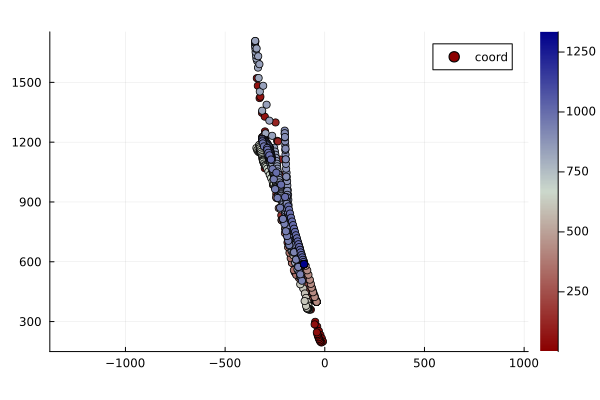

In [67]:
using Plots
get_coord = t -> (t[1], t[2])
get_speed = t -> t[3]

IDX = 1
seg = fst_segments[IDX]
# seg = sliding_window_continous(fst_segments[IDX], WINDOW_SIZE)[24]
time_steps = 1:length(seg)
println("time_steps=$(length(time_steps))")
plot(seg |> xs -> map(get_coord, xs), seriestype = :scatter, label = "coord", aspect_ratio = 1, zcolor = time_steps, color = :redsblues)

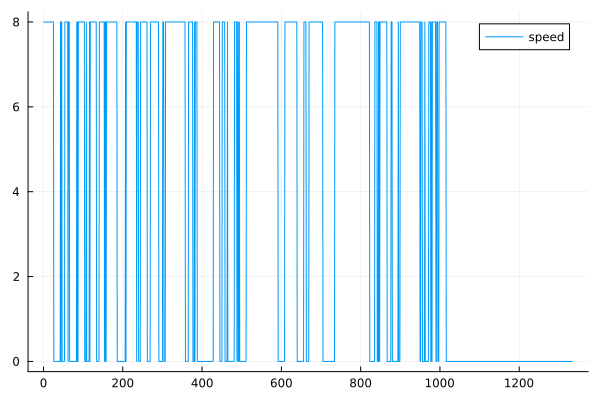

In [68]:
plot(seg |> xs -> map(x -> get_speed(x) |> abs, xs), seriestype = :line, label = "speed")

In [71]:
using Statistics
speed_abs = seg |> xs -> map(x -> get_speed(x) |> abs, xs)
speed_mean = mean(speed_abs)
speed_std = std(speed_abs)
println("speed_mean=$(speed_mean)cm/s")
println("speed_std=$(speed_std)cm/s")
typeof(speed_mean)

speed_mean=3.898050974512744cm/s
speed_std=4.000200194965278cm/s


Float64

In [70]:
# x ranges [-500, 0]
# y ranges [0, 1500]
# speed mean range [0, 9] 
# speed std range [0, 6]
# now, let's design the fuzzy logic system

In [228]:
using FuzzyLogic
fis = @mamfis function decider(xAvg, yAvg, speedMean, speedStd)::output
    xAvg := begin
        domain = -1000:1000
        # left
        XL = GaussianMF(-1000.0, 200.0)
        # optimal
        XO = GaussianMF(-220.0, 180.0)
        # right
        XR = GaussianMF(500.0, 230.0)
    end
    yAvg := begin
        domain = -10:2000
        # optimal
        YO = GaussianMF(0.0, 750.0)
        # negative
        YN = GaussianMF(2000.0, 250.0)
    end
    speedMean := begin
        domain = 0:12
        # low
        SML = GaussianMF(0.0, 2.0)
        # optimal
        SMO = GaussianMF(6.5, 2.0)
        # high
        SMH = GaussianMF(15.0, 2.0)
    end
    speedStd := begin
        domain = 0:8
        # low
        SSL = GaussianMF(0.0, 2.0)
        # optimal
        SSO = GaussianMF(4.0, 1.0)
        # high
        SSH = GaussianMF(8.0, 2.0)
    end
    output := begin
        domain = -1:1
        OL = GaussianMF(-1.0, 0.6)
        OR = GaussianMF(1.0, 0.6)
    end

    and = ProdAnd
    or = ProbSumOr
    implication = ProdImplication

    xAvg == XO && yAvg == YO && speedMean == SMO && speedStd == SSO --> output == OR
    xAvg == XO && yAvg == YO && speedMean == SML && speedStd == SSO --> output == OR
    xAvg == XO && yAvg == YO && speedMean == SMO && speedStd == SSL --> output == OR
    xAvg == XO && yAvg == YO && speedMean == SML && speedStd == SSL --> output == OR
    # Others are default to L
    xAvg == XL --> output == OL
    xAvg == XR --> output == OL
    yAvg == YN --> output == OL
    speedMean == SMH --> output == OL
    speedStd == SSH --> output == OL

    aggregator = ProbSumAggregator
    defuzzifier = CentroidDefuzzifier
end

decider

Inputs:
-------
xAvg ∈ [-1000, 1000] with membership functions:
    XL = GaussianMF{Float64}(-1000.0, 200.0)
    XO = GaussianMF{Float64}(-220.0, 180.0)
    XR = GaussianMF{Float64}(500.0, 230.0)

yAvg ∈ [-10, 2000] with membership functions:
    YO = GaussianMF{Float64}(0.0, 750.0)
    YN = GaussianMF{Float64}(2000.0, 250.0)

speedMean ∈ [0, 12] with membership functions:
    SML = GaussianMF{Float64}(0.0, 2.0)
    SMO = GaussianMF{Float64}(6.5, 2.0)
    SMH = GaussianMF{Float64}(15.0, 2.0)

speedStd ∈ [0, 8] with membership functions:
    SSL = GaussianMF{Float64}(0.0, 2.0)
    SSO = GaussianMF{Float64}(4.0, 1.0)
    SSH = GaussianMF{Float64}(8.0, 2.0)


Outputs:
--------
output ∈ [-1, 1] with membership functions:
    OL = GaussianMF{Float64}(-1.0, 0.6)
    OR = GaussianMF{Float64}(1.0, 0.6)


Inference rules:
----------------
(xAvg is XO ∧ (yAvg is YO ∧ (speedMean is SMO ∧ speedStd is SSO))) --> output is OR
(xAvg is XO ∧ (yAvg is YO ∧ (speedMean is SML ∧ speedStd is SSO))

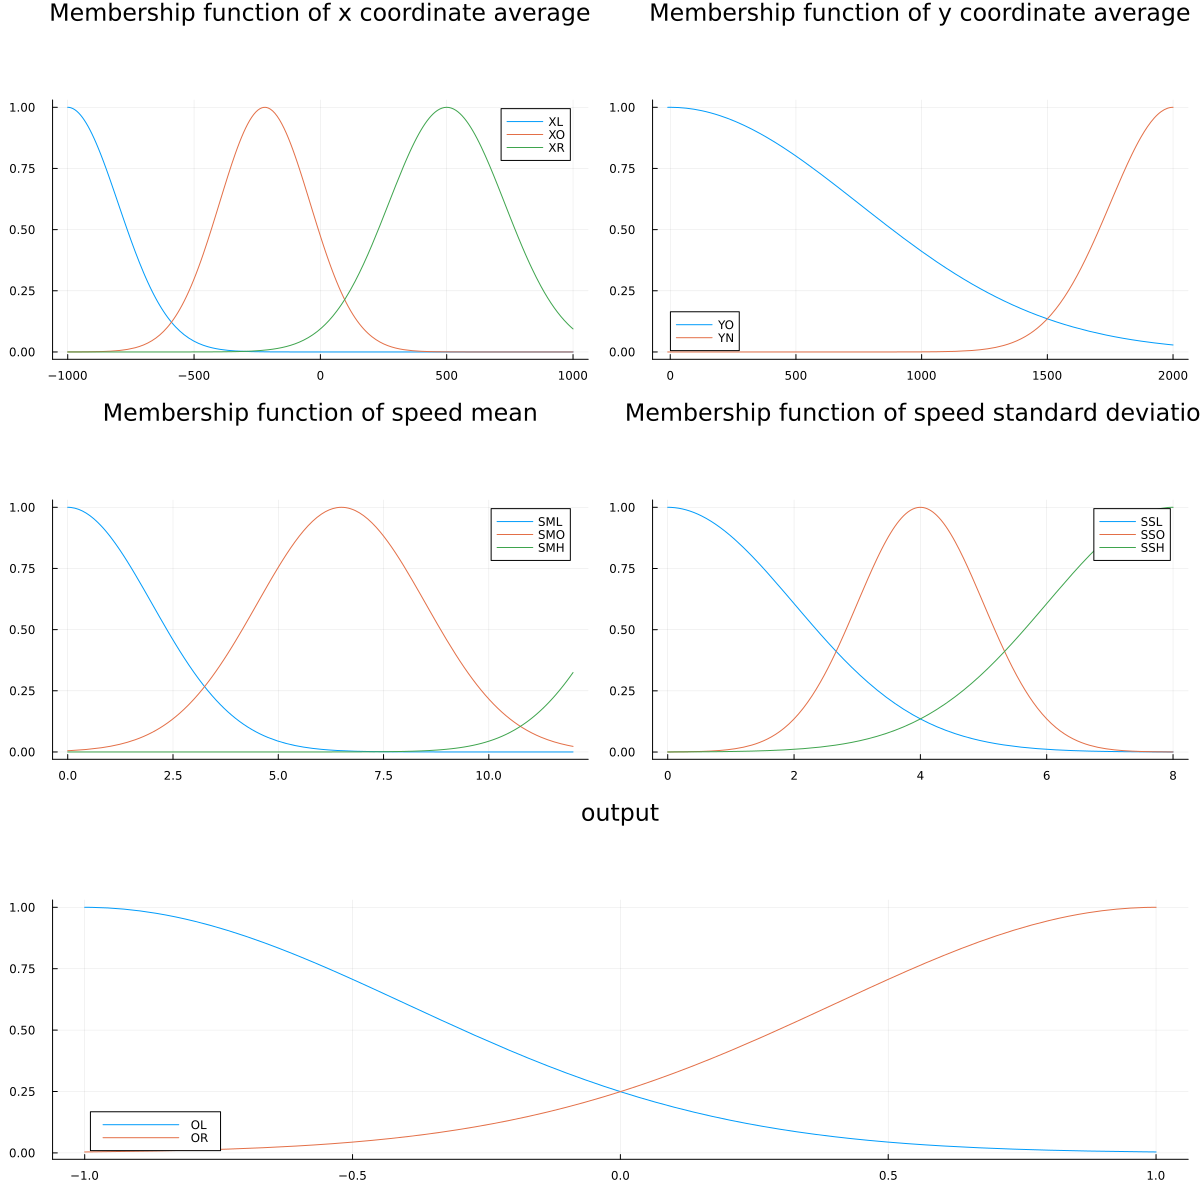

In [229]:
pXAvg = plot(fis, :xAvg)
# plot title and title are different
plot!(pXAvg, plot_title = "Membership function of x coordinate average")
pYAvg = plot(fis, :yAvg)
plot!(pYAvg, plot_title = "Membership function of y coordinate average")
pSpeedMean = plot(fis, :speedMean)
plot!(pSpeedMean, plot_title = "Membership function of speed mean")
pSpeedStd = plot(fis, :speedStd)
plot!(pSpeedStd, plot_title = "Membership function of speed standard deviation")
pOutput = plot(fis, :output)
layout = @layout [a b; c d; e]
p = plot(pXAvg, pYAvg, pSpeedMean, pSpeedStd, pOutput, layout = layout, size = (1200, 1200))
display(p)

In [232]:
fis(xAvg = 50, yAvg = 100, speedMean = 6, speedStd = 4)

1-element Dictionaries.Dictionary{Symbol, Float64}
 :output │ 0.06883753165922568